# NLP for Disaster Tweets

This is an exercise in natural language processing as part of a course in Deep Learning taken at the Univeristy of Colorado at Boulder. The dataset is from an old Kaggle competition and can be found at https://www.kaggle.com/c/nlp-getting-started/overview. The intent of this exercise was an introduction to NLP via deep learning methodologies (in particular LSTM).

## 0) Setup

### Import Required Libraries

We start by importing various required (probably some unnecessary libraries are included here..) libraries for the notebook. **NOTE that you may need to uncomment the first cell below if you do not have nltk installed. First, open a cmd prompt and execute "pip install nltk" An additional pop-up window may then open once you execute the cell below and you can select Download. The goal is to execute the cell with all the import/from directives without error.

In [2]:
#import nltk
#nltk.download()

In [174]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import LSTM,  Embedding, BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

### Data Preparation

Here we will load in the data and take a peak at the first few rows. From this we get the hunch that the "text" column contains the tweest that will form the crux of the datapoints we will be modelling.

In [95]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [250]:
test_data.head()

,id,keyword,location,text,Text_Clean,Text_Lemmatized
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake cities stay safe,heard earthquake city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest spot pond geese fleeing street save,forest spot pond goose fleeing street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,typhoon soudelor kill china taiwan


## 1) Exploratory Data Analysis (EDA)

#### Data Balance

The first thing we will do is take a look at the distribution of our data to assess its "balance." For a problem of cancer research, an initial concern could be havily unbalanced data that contains much more non-cancerous than cancerous samples. However, we find that the data is relatively well balanced, with an approximate 60/40 split between Non-Cancerous and Cancerous samples. Accordingly, data balance/distribution should not be a major concern in our modelling decisions. Nevertheless, since we have a binary problem we will want to keep this split in mind and also take a look at precision and recall metrics in addition to accuracy to ensure that our model is performing meaningfully better than just a random guess.

In [241]:
x = train_data.target.value_counts()
x.head()

target
0    4342
1    3271
Name: count, dtype: int64

Text(0.5, 1.0, 'Disaster Tweet Class Distributions')

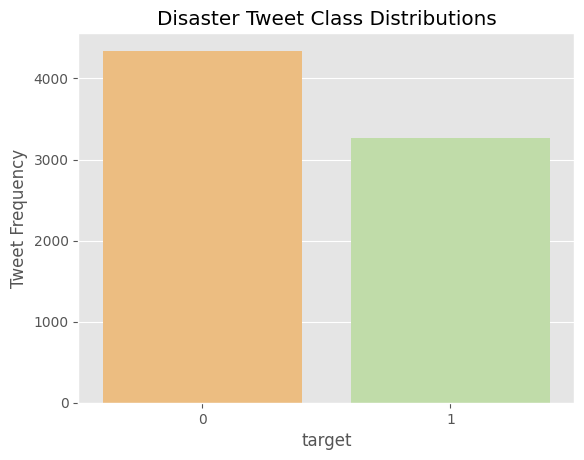

In [14]:
sns.barplot(x, palette='Spectral')
plt.gca().set_ylabel('Tweet Frequency')
plt.title('Disaster Tweet Class Distributions')

#### Character Count by Class

The first thing we will

Text(0.5, 0.98, 'Number of Characters in Tweets by Class')

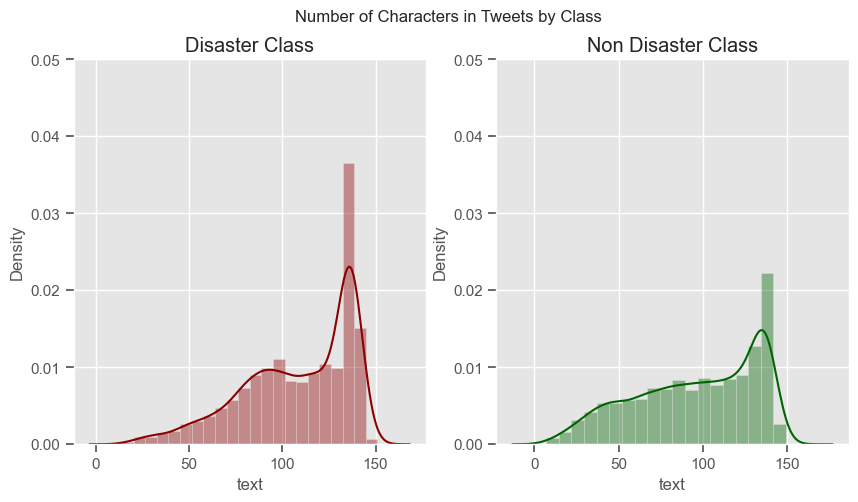

In [242]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
dtl = train_data[train_data['target']==1]['text'].str.len()
# This would be the lambda/linqy type way to do that, but seems actually more complicated in Python vs above
#dtl = [len(x[train_data.columns.get_loc('text')]) for x in train_data.values if x[train_data.columns.get_loc('target')] == 1]
sns.distplot(dtl.map(lambda x: np.mean(x)), ax=ax1, color='darkred')
#ax1.hist(dtl, color='red')
ax1.set_ylim([0, 0.05])
ax1.set_title('Disaster Class')

ndtl = train_data[train_data['target']==0]['text'].str.len()
# This would be the lambda/linqy type way to do that, but seems actually more complicated in Python vs above
#ndtl = [len(x[train_data.columns.get_loc('text')]) for x in train_data.values if x[train_data.columns.get_loc('target')] == 0]
sns.distplot(ndtl.map(lambda x: np.mean(x)), ax=ax2, color='darkgreen')
#ax2.hist(ndtl, color='green')
ax2.set_ylim([0, 0.05])
ax2.set_title('Non Disaster Class')

fig.suptitle('Number of Characters in Tweets by Class')

#### Word Count by Class

The first thing we will

Text(0.5, 0.98, 'Words in Tweets by Class')

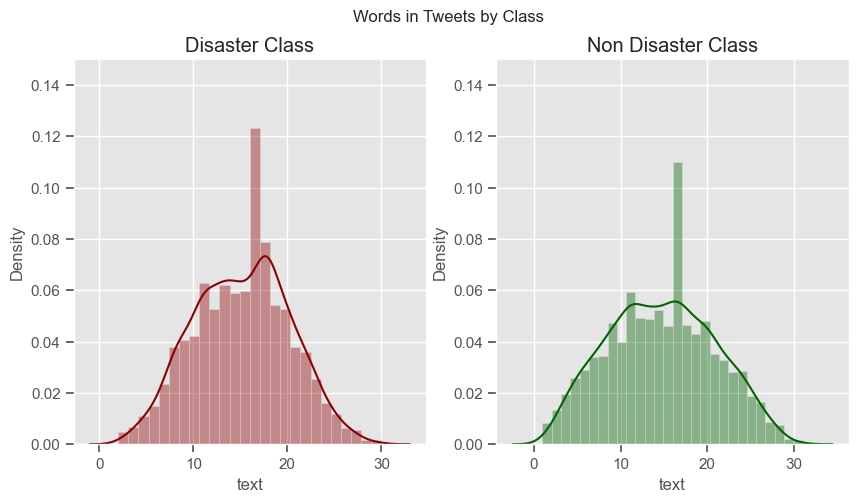

In [243]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
dtnw = train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
sns.distplot(dtnw.map(lambda x: np.mean(x)), ax=ax1, color='darkred')
#ax1.hist(dtnw, color='red')
ax1.set_ylim([0, 0.15])
ax1.set_title('Disaster Class')

ndtnw = train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
sns.distplot(ndtnw.map(lambda x: np.mean(x)), ax=ax2, color='darkgreen')
#ax2.hist(ndtnw,color='green')
ax2.set_ylim([0, 0.15])
ax2.set_title('Non Disaster Class')
fig.suptitle('Words in Tweets by Class')

#### Word Length by Class

The first thing we will

Text(0.5, 0.98, 'Average Word Length in Tweets by Class')

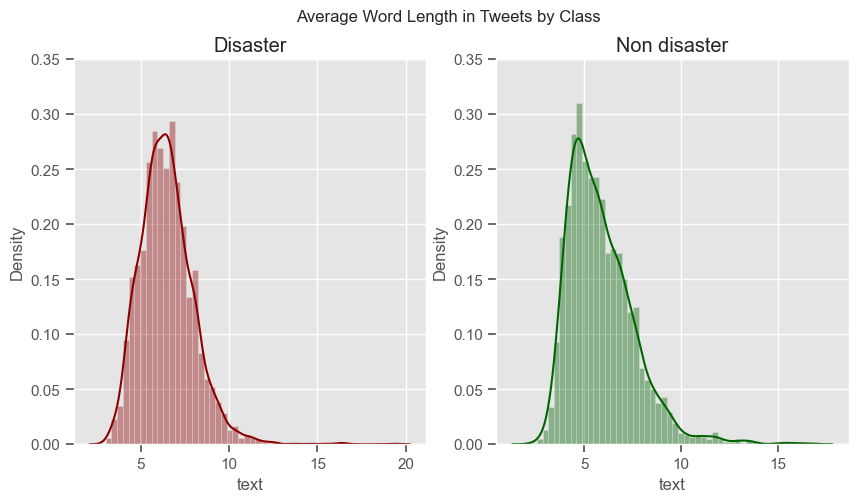

In [244]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
dtawl = train_data[train_data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(dtawl.map(lambda x: np.mean(x)),ax=ax1,color='darkred')
ax1.set_ylim([0, 0.35])
ax1.set_title('Disaster')


ndtawl = train_data[train_data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(ndtawl.map(lambda x: np.mean(x)),ax=ax2,color='darkgreen')
ax2.set_ylim([0, 0.35])
ax2.set_title('Non disaster')
fig.suptitle('Average Word Length in Tweets by Class')

### Data Cleaning and Preprocessing

#### Load Custom Stopwords and Build Function to Clean -> Lemmatize Tweets

NLTK is the Natural Language ToolKit. A good intro to lemmatization can be found here: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/. In short, lemmatization attempts to transform words to their most meaningful/comparative representation across objects. Additionally, a fantastic augmented text file of stopwords was found at https://gist.github.com/sebleier/554280. This adds to the standard NLTK list of stopwords some obvious choices such as "said". We will use this list rather than the default list available in the NLTK.

In [69]:
# This is the file of augmented stop words vs the standard corpus available in the nltk.
gist_file = open("gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    custom_stop = content.split(",")
finally:
    gist_file.close()

In [80]:
def preprocess_rawtext(raw_data, raw_key, stopwords):
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    def lemmatize_text(text):
        lem_text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
        return " ".join(lem_text)
        
    #Casing
    raw_data["Text_Clean"] = raw_data[raw_key].str.lower()
    # Emojis
    raw_data["Text_Clean"] = raw_data["Text_Clean"].apply(remove_emoji)
    # Punctuations
    raw_data["Text_Clean"] = raw_data["Text_Clean"].str.replace('[^\w\s]','',regex=True)
    # Numeric characters
    raw_data["Text_Clean"] = raw_data["Text_Clean"].str.replace('\d+','',regex=True)
    # Stopwords
    raw_data["Text_Clean"] = raw_data["Text_Clean"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # Extra spaces
    raw_data["Text_Clean"] = raw_data["Text_Clean"].apply(lambda x: re.sub(' +', ' ', x))
    # lemmatize words (see note above for link to descriptioon of lemmatization)
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    raw_data["Text_Lemmatized"] = raw_data["Text_Clean"].apply(lemmatize_text)

In [96]:
preprocess_rawtext(train_data, 'text', custom_stop)
preprocess_rawtext(test_data, 'text', custom_stop)

In [82]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               7613 non-null   int64 
 1   keyword          7552 non-null   object
 2   location         5080 non-null   object
 3   text             7613 non-null   object
 4   target           7613 non-null   int64 
 5   Text_Clean       7613 non-null   object
 6   Text_Lemmatized  7613 non-null   object
dtypes: int64(2), object(5)
memory usage: 416.5+ KB


#### Let's visualize the top 20 words from the clean text and lemmatized text. The results here are interesting in that we do see differences between these two rankings.

Additionally, we see that many of the top twenty words for disaster tweets are recognizably negative - i.e. "disaster", "suicide", "hiroshima", etc, whereas the non-disaster tweets, with the peculiar exception of "emergency", are more neutral.

In [83]:
def top_frequent_words(data, title):
    data_split= data.str.split()
    data_list=data_split.values.tolist()
    corpus=[word for i in data_list for word in i]
    counter=Counter(corpus)
    mostCommon=counter.most_common()
    x, y=[], []
    for word,count in mostCommon[:20]:
        if (word not in set(custom_stop)):
            x.append(word)
            y.append(count) 
    sns.set(rc={"figure.figsize":(20, 8)}) #width=3, #height=4
    sns.set_style("ticks")
    plot = sns.barplot(x=x,y=y)
    plt.title(title,fontsize=30)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize = 20)

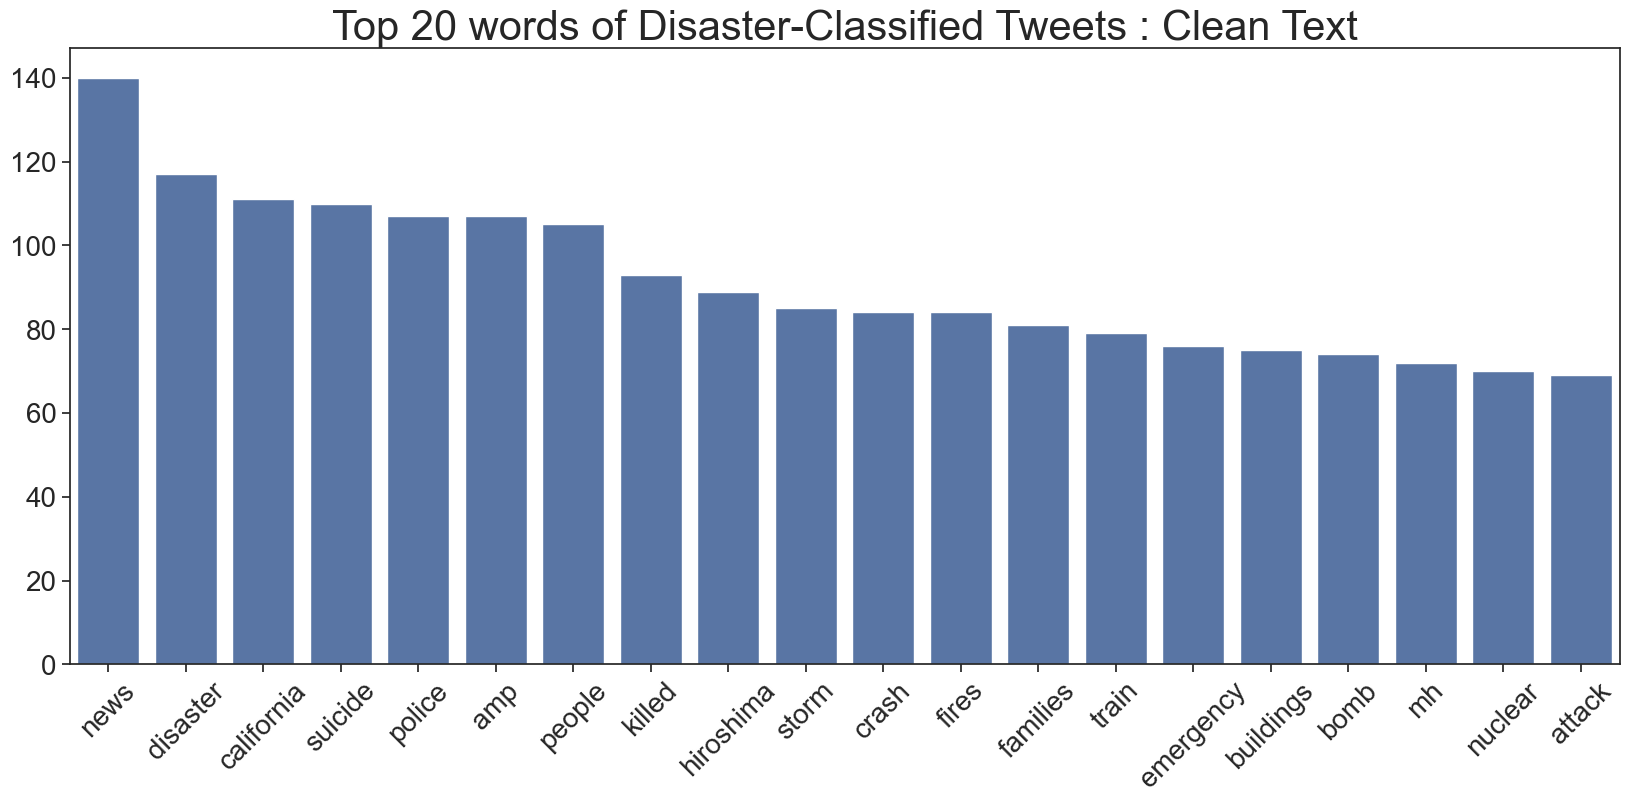

In [85]:
top_frequent_words(train_data[train_data['target']==1]["Text_Clean"], 'Top 20 words of Disaster-Classified Tweets : Clean Text')

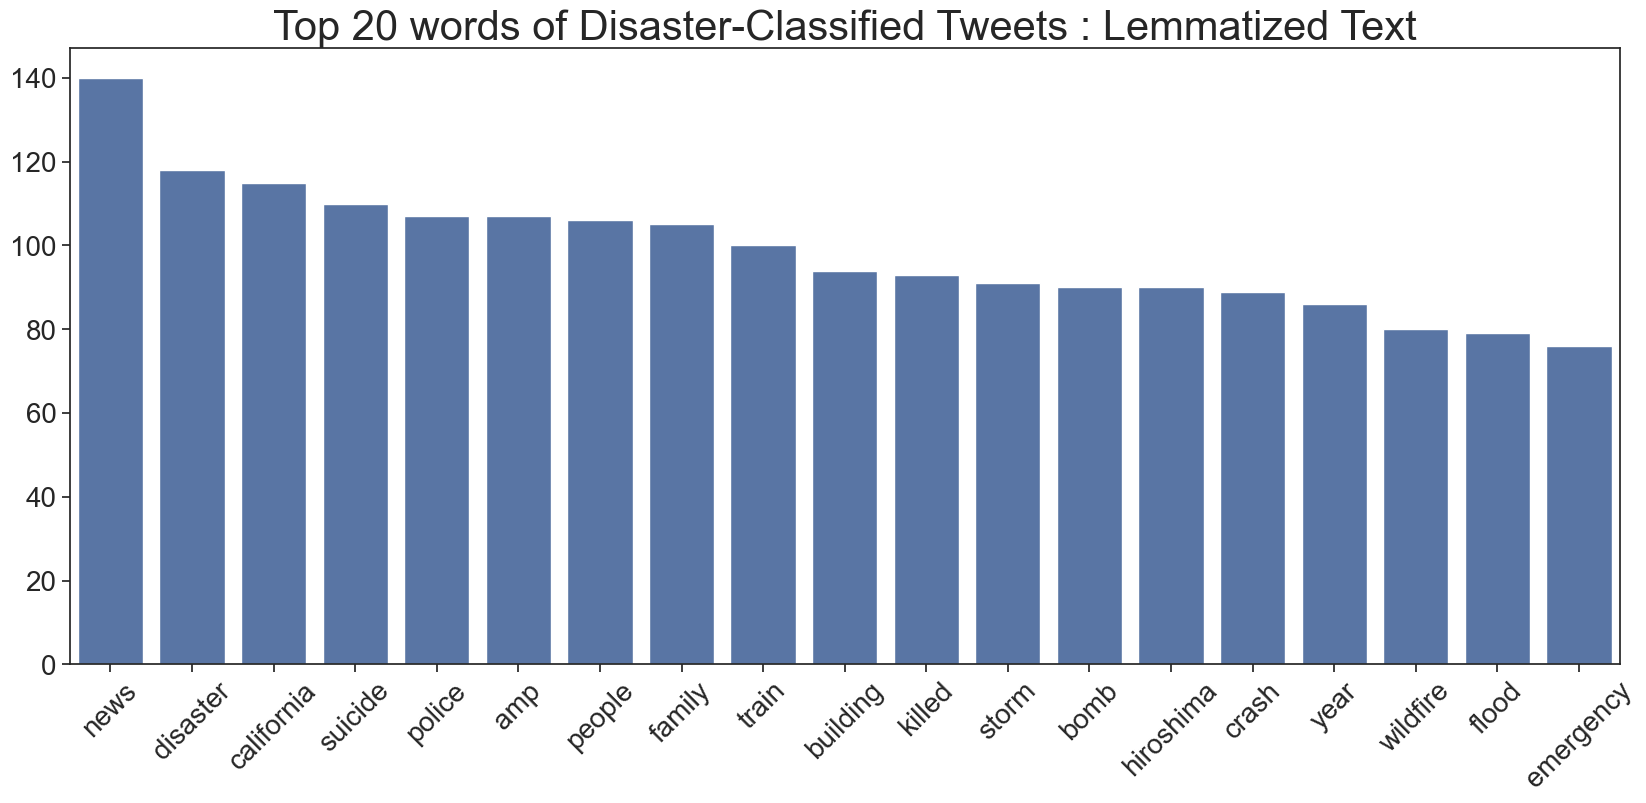

In [86]:
top_frequent_words(train_data[train_data['target']==1]["Text_Lemmatized"], 'Top 20 words of Disaster-Classified Tweets : Lemmatized Text')

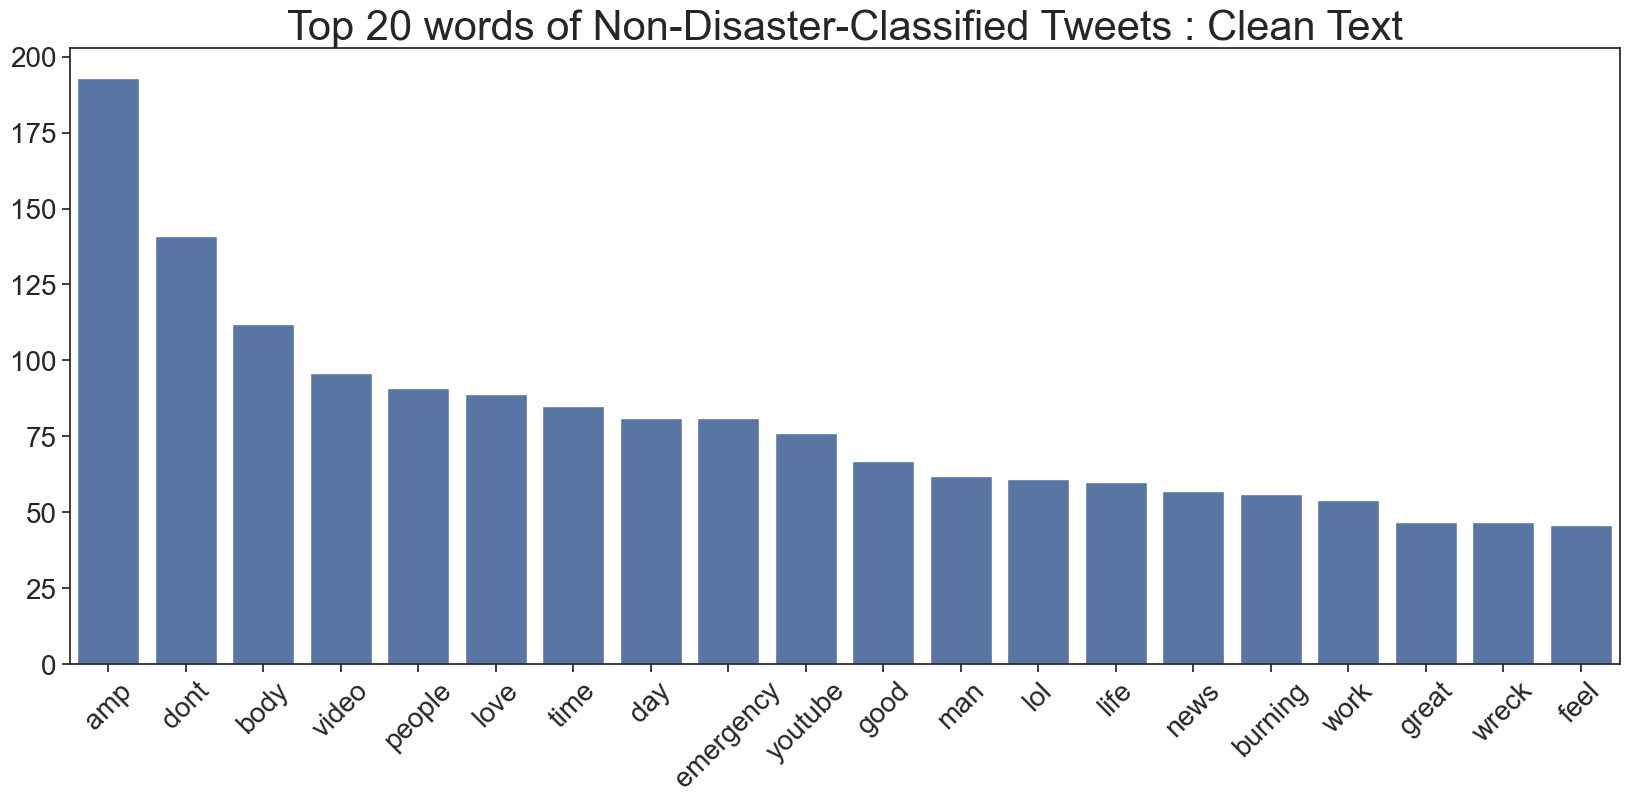

In [87]:
top_frequent_words(train_data[train_data['target']==0]["Text_Clean"], 'Top 20 words of Non-Disaster-Classified Tweets : Clean Text')

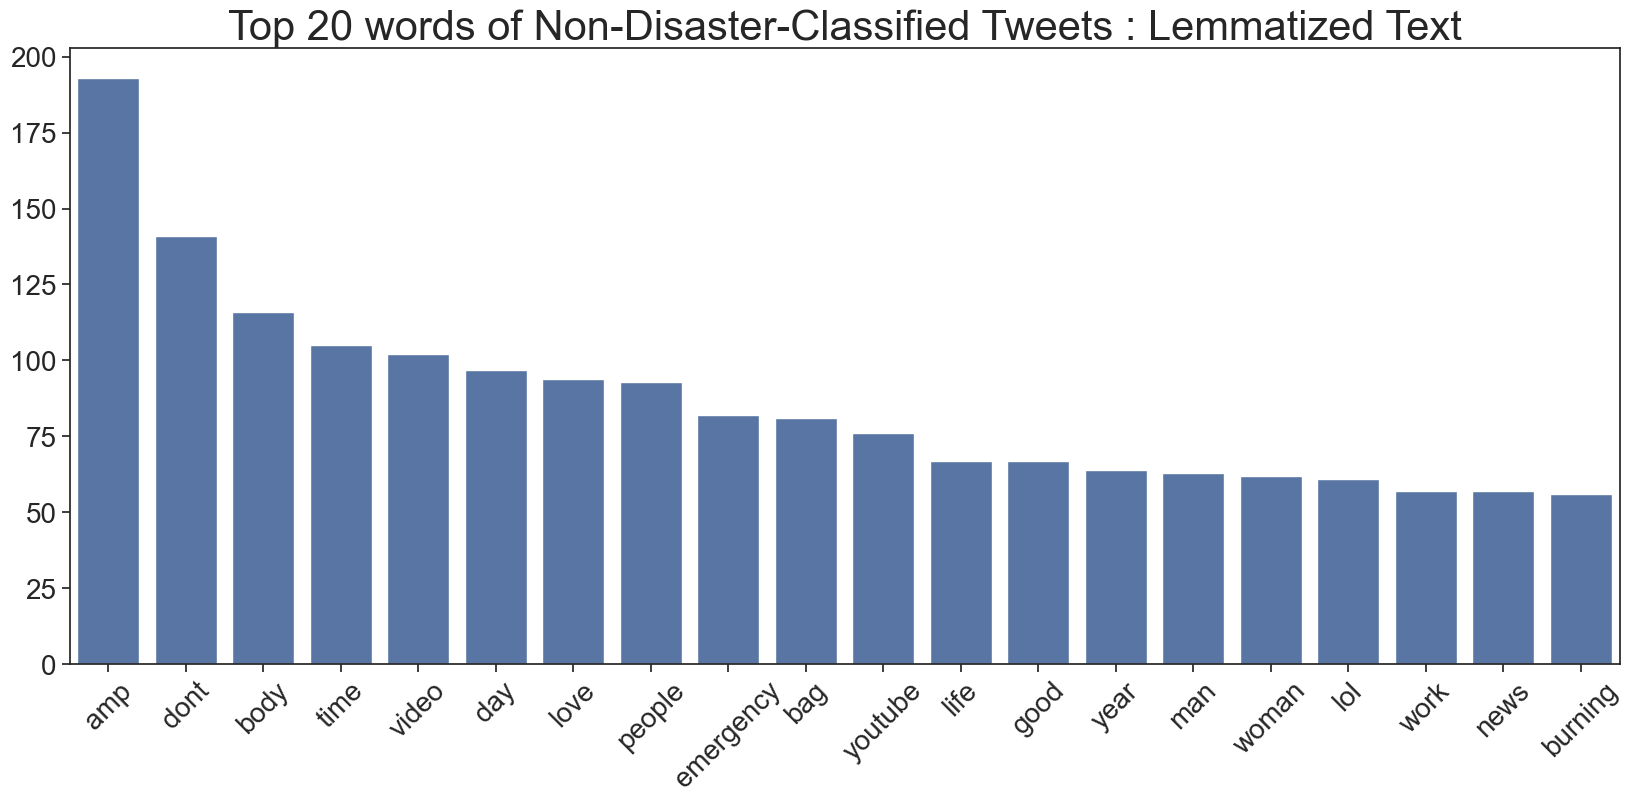

In [88]:
top_frequent_words(train_data[train_data['target']==0]["Text_Lemmatized"], 'Top 20 words of Non-Disaster-Classified Tweets : Lemmatized Text')

#### Tokenization, Sequencing, and SMOTE Balancing

Now let's tokenize the text and sequence it. Tokenization is a process that converts text to simpler representations know as tokens (as will be shown in an extract of the tokenizer, these nevertheless ten to be very similar to the lemmatized text). Sequencing transforms each text in texts to a sequence of integers, essentially just taking each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Finally, I use SMOTE to fix the class imbalance (although as shown above, this doesn't really seem to be a significant issue in the data).

In [97]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["Text_Lemmatized"])
X = tokenizer.texts_to_sequences(train_data["Text_Lemmatized"])
X_test = tokenizer.texts_to_sequences(test_data["Text_Lemmatized"])
max_length = 100
X = pad_sequences(X, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [247]:
word_index = tokenizer.word_index
print(word_index)

{'amp': 1, 'people': 2, 'news': 3, 'dont': 4, 'video': 5, 'time': 6, 'emergency': 7, 'disaster': 8, 'year': 9, 'body': 10, 'day': 11, 'building': 12, 'police': 13, 'family': 14, 'life': 15, 'crash': 16, 'storm': 17, 'california': 18, 'burning': 19, 'bomb': 20, 'suicide': 21, 'train': 22, 'flood': 23, 'car': 24, 'man': 25, 'death': 26, 'attack': 27, 'love': 28, 'nuclear': 29, 'fire': 30, 'today': 31, 'war': 32, 'youtube': 33, 'dead': 34, 'killed': 35, 'accident': 36, 'woman': 37, 'hiroshima': 38, 'weapon': 39, 'good': 40, 'watch': 41, 'wildfire': 42, 'bag': 43, 'service': 44, 'injury': 45, 'collapse': 46, 'work': 47, 'bombing': 48, 'plan': 49, 'mh': 50, 'thing': 51, 'army': 52, 'mass': 53, 'fatality': 54, 'school': 55, 'lol': 56, 'hostage': 57, 'fear': 58, 'black': 59, 'city': 60, 'û': 61, 'forest': 62, 'photo': 63, 'kill': 64, 'feel': 65, 'hot': 66, 'fatal': 67, 'god': 68, 'northern': 69, 'water': 70, 'house': 71, 'great': 72, 'obama': 73, 'legionnaire': 74, 'bomber': 75, 'live': 76, '

In [100]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, train_data['target'])

#### The final step before model building is to generate the train/validate split of the data

In [101]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## 2) Model Building

I start by building a pretty simple LSTM model, mainly as a way to confirm that upstream data processing was conducted in a way to allow proper fitting of models, and also that the model is set up appropriately to at least approximately converge to an optimal solution.

In [111]:
# Building a simple LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(units=1, activation='sigmoid'))

In [112]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
# Training the model
simple_log = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6200 - loss: 0.6220 - val_accuracy: 0.7530 - val_loss: 0.4897
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.8763 - loss: 0.2997 - val_accuracy: 0.7415 - val_loss: 0.5746
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.9518 - loss: 0.1377 - val_accuracy: 0.7133 - val_loss: 0.7270
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9709 - loss: 0.0895 - val_accuracy: 0.7024 - val_loss: 0.8993
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9817 - loss: 0.0558 - val_accuracy: 0.7121 - val_loss: 1.0810
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9878 - loss: 0.0368 - val_accuracy: 0.7127 - val_loss: 1.1108
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9928 - loss: 0.0253 - val_accuracy: 0.7191 - val_loss: 1.2500
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9939 - loss: 0.0192 - 

Here I build a function to plot some performance metrics to confirm that the model is converging. We certainly see this in the training data, so I'm comfortable enough that the work so far has been implemented appropriately. It will still be seen if a more complex and tuned model can remedy the poor performance of the validation metrics, however.

In [114]:
def plot_metric(training_log, metric_name, title):
    plt.plot(training_log.history[metric_name])
    plt.plot(training_log.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title(title)
    plt.show()

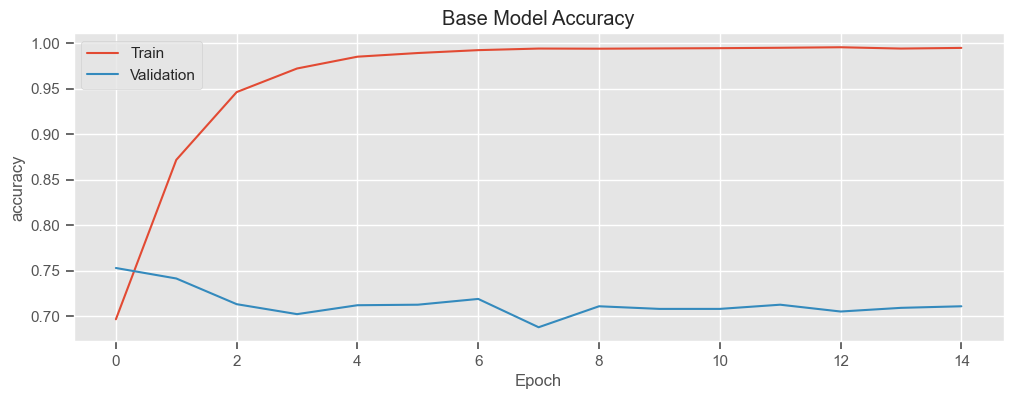

In [115]:
plt.figure(figsize=(12, 4))
plot_metric(simple_log, 'accuracy', 'Base Model Accuracy')

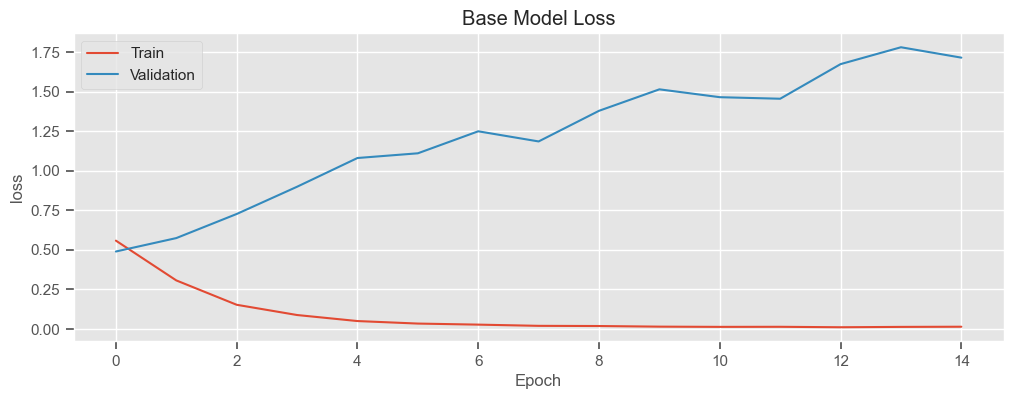

In [116]:
plt.figure(figsize=(12, 4))
plot_metric(simple_log, 'loss', 'Base Model Loss')

Here I build a more complicated model, but really this just serves as a launching point for the hyperparameter tuning of the next section.

In [133]:
# Building a more complex LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [134]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
# Training the model
training_log = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.6402 - loss: 0.6199 - val_accuracy: 0.7490 - val_loss: 0.5077
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.8870 - loss: 0.2840 - val_accuracy: 0.7317 - val_loss: 0.6831
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9622 - loss: 0.1160 - val_accuracy: 0.7196 - val_loss: 0.7647
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.9762 - loss: 0.0687 - val_accuracy: 0.7064 - val_loss: 1.3942
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9894 - loss: 0.0408 - val_accuracy: 0.7294 - val_loss: 1.2301
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9892 - loss: 0.0416 - val_accuracy: 0.7191 - val_loss: 1.1493
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.9929 - loss: 0.0274 - val_accuracy: 0.7093 - val_loss: 1.6725
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.9942 - loss: 0

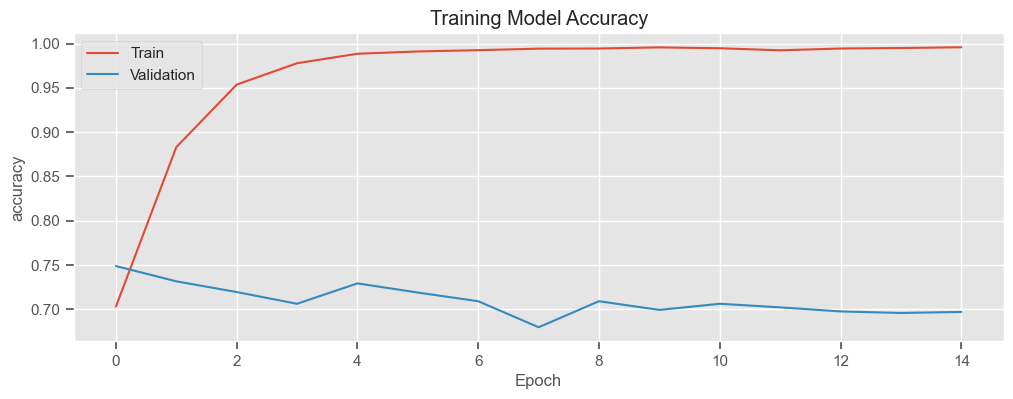

In [136]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'accuracy', 'Training Model Accuracy')

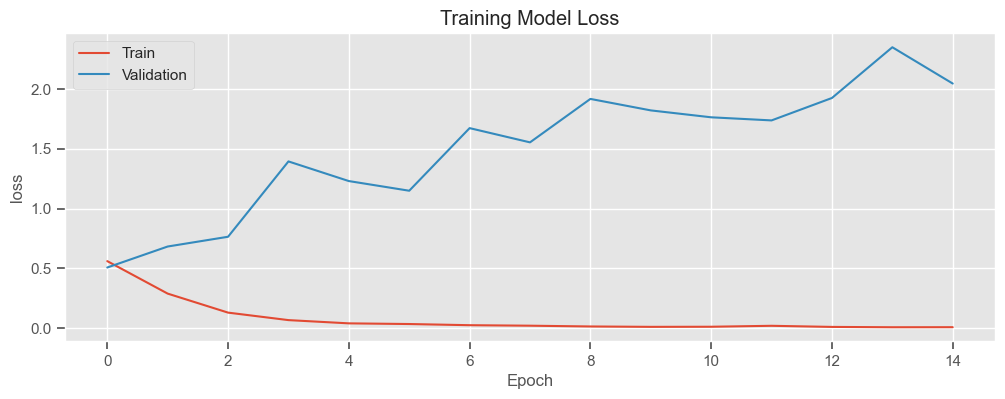

In [137]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'loss', 'Training Model Loss')

## 3) Hyperparameter Tuning

Now it's time for hyperparameter tuning. Below is a function that allows tuning of a number of different configurations, including the laerning rate, units of the LSTM layers, the dropout rates, the recurrent dropout rates, and also the size of the dense layers that make up the neural network classifier in the second phase of the model.

In [234]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))

    # LSTM Layer 1
    model.add(Bidirectional(LSTM(units=hp.Int("lstm_units1", min_value=5, max_value=10, step=1), 
                                 dropout=hp.Float("dropout1", min_value=0.15, max_value=0.6, step=0.025), 
                                 recurrent_dropout=hp.Float("recurrent_dropout1", min_value=0.15, max_value=0.6, step=0.025),
                                 kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.001),
                                 bias_regularizer=regularizers.L2(0.0001),
                                 return_sequences=True)))

    # LSTM Layer 2
    model.add(Bidirectional(LSTM(units=hp.Int("lstm_units2", min_value=5, max_value=10, step=1), 
                                 dropout=hp.Float("dropout2", min_value=0.15, max_value=0.6, step=0.025), 
                                 recurrent_dropout=hp.Float("recurrent_dropout2", min_value=0.15, max_value=0.6, step=0.025),
                                 kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.001),
                                 bias_regularizer=regularizers.L2(0.0001))))

    # Neural Network/Classifier Layer
    model.add(Dense(units=hp.Int("dense_units1", min_value=64, max_value=256, step=16), kernel_regularizer=regularizers.L2(0.0005), activation='relu'))
    model.add(Dense(units=hp.Int("dense_units2", min_value=24, max_value=48, step=4), kernel_regularizer=regularizers.L2(0.0005), activation='relu'))
    model.add(Dense(units=hp.Int("dense_units3", min_value=8, max_value=16, step=2), kernel_regularizer=regularizers.L2(0.00025), activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001, 0.00005, 0.00001])), loss='binary_crossentropy', metrics = ['accuracy'])
    return model

In [235]:
tuner = kt.RandomSearch(
    build_model,
    overwrite=True,
    objective='val_loss',
    max_trials=5)

In [236]:
keras.utils.set_random_seed(1)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, start_from_epoch=1)
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Trial 5 Complete [00h 05m 05s]
val_loss: 0.6474145650863647

Best val_loss So Far: 0.5736246109008789
Total elapsed time: 00h 25m 33s


#### Here I clone the tuned model and run another fitting so that I am able to plot the same performance metrics as above. I am getting unexpected behavior here that I need to look into. Meaning, I seem to be unable to replicate the reported results for the best tuned model (a val_loss of ~ 0.57), and get divergence in the validation results that are typical for an overfit model.

In [237]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'lstm_units1': 8, 'dropout1': 0.42500000000000004, 'recurrent_dropout1': 0.5, 'lstm_units2': 9, 'dropout2': 0.55, 'recurrent_dropout2': 0.55, 'dense_units1': 240, 'dense_units2': 32, 'dense_units3': 16, 'learning_rate': 0.0005}


In [238]:
best_model_clone = tuner.hypermodel.build(tuner.oracle.get_best_trials(1)[0].hyperparameters)

In [248]:
best_model_clone.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       2,556,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 16)             │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 18)                  │           1,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 240)                 │           4,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           7,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,738,853 (29.52 MB)

 Trainable params: 2,579,617 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,159,236 (19.68 MB)

In [239]:
# Compiling the model
best_model_clone.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [240]:
# Training the model
tuned_log = best_model_clone.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 37s 149ms/step - accuracy: 0.5058 - loss: 0.8808 - val_accuracy: 0.7133 - val_loss: 0.6084
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.7669 - loss: 0.5422 - val_accuracy: 0.7473 - val_loss: 0.6269
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.8979 - loss: 0.3078 - val_accuracy: 0.7427 - val_loss: 0.7694
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.9462 - loss: 0.1933 - val_accuracy: 0.7283 - val_loss: 0.9254
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.9626 - loss: 0.1469 - val_accuracy: 0.7277 - val_loss: 1.0062
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.9744 - loss: 0.1172 - val_accuracy: 0.7162 - val_loss: 1.0556
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.9794 - loss: 0.1008 - val_accuracy: 0.7139 - val_loss: 1.1150
Epoch 8/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.9836 - loss: 0

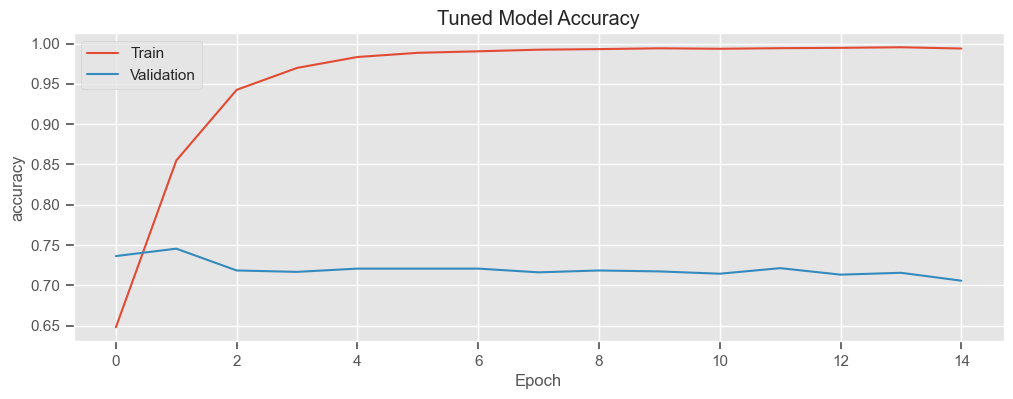

In [215]:
plt.figure(figsize=(12, 4))
plot_metric(tuned_log, 'accuracy', 'Tuned Model Accuracy')

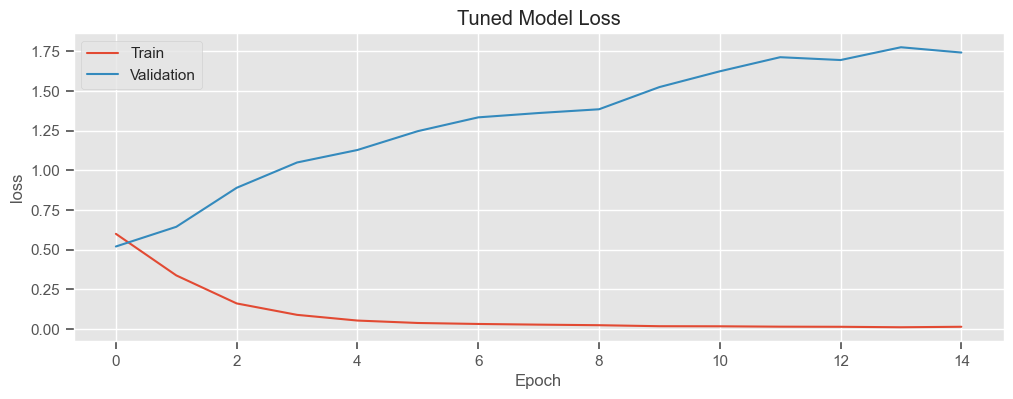

In [216]:
plt.figure(figsize=(12, 4))
plot_metric(tuned_log, 'loss', 'Tuned Model Loss')

#### Use the tuned model to predict on the testing data and submit for the Kaggle competition.

In [251]:
predictions = best_model_clone.predict(X_test)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(test_data)}")
binary_predictions = (predictions >= 0.5).astype(int).flatten() # convert the sigmoid 0-1 to either 0 or 1
print(len(binary_predictions))

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step
Number of predictions: 3263
Number of test samples: 3263
3263


In [253]:
submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = test_data['id']
submission_dataframe['target'] = binary_predictions
submission_dataframe.to_csv('submission.csv', index=False)

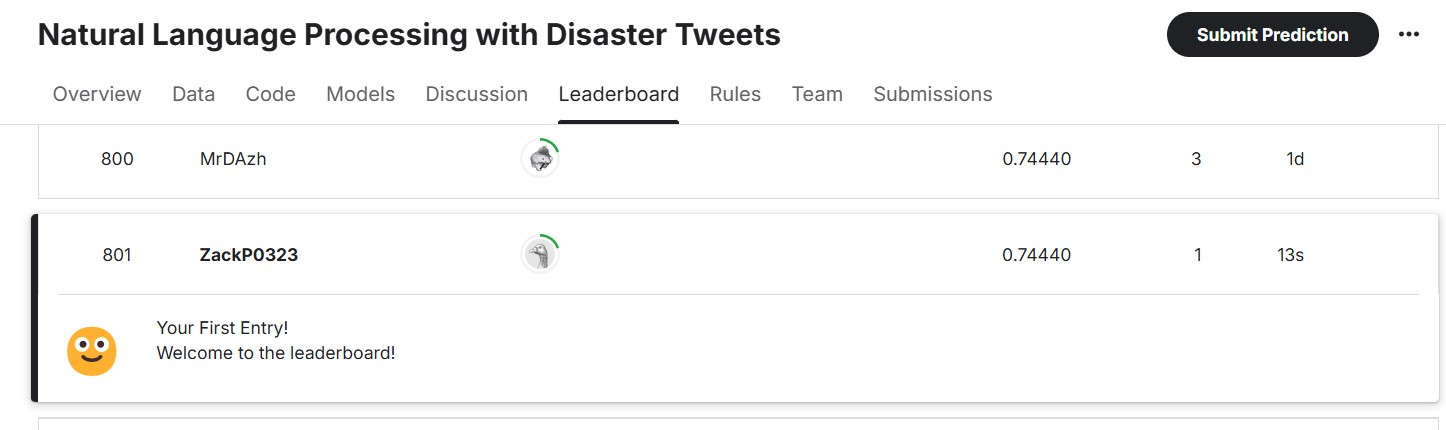

In [254]:
from PIL import Image
pil_im = Image.open('Leaderboard_Screenshot.jpg')
display(pil_im)

## 4) Conclusion

Here I showed how LSTM models could be used for sentiment classification of text (tweet data). The training models performed well, however I need to do further research to remedy what appears to be a clasically overfit model that is not generalizing to new data.